CPU is fine for the quick demos. GPU is necessary for the benchmark. A T4 (free in
Google Colab) is sufficient.

In [1]:
from functools import partial
import time
from typing import Any, Callable, Collection, TypeVar

try:
    from IPython.display import clear_output
except ModuleNotFoundError:
    clear_output = lambda *args, **kwargs: None

import pandas as pd
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GPT2LMHeadModel,
    PreTrainedModel,
    PreTrainedTokenizerBase,
)
from transformers.modeling_outputs import CausalLMOutput

In [2]:
FORCE_CPU = not torch.cuda.is_available()
# MPS is just incorrect

# Implementation

For the tree-based extension, here's one naive approach.

Given a number of branches, $m$, parallel-decode $m$ sequences from the small model.
Each branch contains $\gamma$ tokens. Next, pick the branch with the greatest $n$. This
idea relies on parallel-decoding (parallelization along the batch dimension in a
transformer) being fast-enough to get a greater $n$ (due to sampling more sequences). It
might be worth asking what the mean of $\max_{j = 1, 2, \dots, m} n_j$ is, i.e., the
mean of the max of $m$ $\gamma$-capped Geometric r.v.'s w/ success probability $\beta$.
It's directly/positively related to $m$, but if the strength of the relationship is
weak, this approach will take longer than the non-tree approach. $\gamma$ will also need
to be set to a higher value to increase the mean. I'll need to benchmark on a GPU so
that parallel-decoding has the intended speedup.

A potential shortcut is to intermediately terminate branches which generated a rejected
token. This requires querying whether or not the next generated token is rejected during
parallel decoding. It'd require manually removing parts of the KV cache during
generation, i.e., slicing out parts of the batch dimension of the cache. For now, I'll
implement the approach w/o this shortcut.

In [3]:
# helpers
def process_logits(logits: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    # dumb version of HF LogitsProcessor
    # TODO: can support more arbitrary processing like top k
    logits /= temperature
    return logits.softmax(dim=-1)  # assume vocab dim is last


def encoding_from_input_ids(
    input_ids: torch.Tensor, device: str | torch.device
) -> dict[str, torch.Tensor]:
    """
    Creates the attention mask and moves the tensors to `device`.
    """
    return {
        "input_ids": input_ids.to(device),
        "attention_mask": torch.ones_like(input_ids, device=device),
    }

In [ ]:
@torch.no_grad()
def spec_dec_next_tokens(
    model_p: PreTrainedModel,
    model_q: PreTrainedModel,
    input_ids: torch.Tensor,
    gamma: int,
    pad_token_id: int,
    num_branches: int,
    **process_logits_kwargs,
) -> torch.Tensor:
    """
    Generates up to `gamma + 1` next tokens given `input_ids` via speculative decoding.
    The number of branches refers to the number of sequences generated, from which the
    sequence with the maximum number of accepted tokens is used.

    Parameters
    ----------
    model_p : PreTrainedModel
        Big model to generate completions from
    model_q : PreTrainedModel
        Small model to draft completions from
    input_ids : torch.Tensor
        Prompt token IDs
    gamma : int
        Maximum number of tokens to generate
    pad_token_id : int
        e.g., `tokenizer.eos_token_id` if `tokenizer.pad_token_id is None`
    num_branches : int
        Number of draft sequences to generate

    Returns
    -------
    torch.Tensor
        Completion token IDs
    """
    # TODO: cache KV across this function's calls, since the input_ids is always
    # concatted to.

    if gamma < 1:
        raise ValueError(f"gamma must be at least 1. Got {gamma}")
    if num_branches < 1:
        raise ValueError(f"num_branches must be at least 1. Got {num_branches}")

    if num_branches > 1:
        generate_kwargs = dict(
            num_return_sequences=num_branches,
        )
    else:
        generate_kwargs = dict()
    encoding = encoding_from_input_ids(input_ids, device=model_q.device)
    out = model_q.generate(
        **encoding,
        use_cache=True,
        max_new_tokens=gamma,
        output_logits=True,
        return_dict_in_generate=True,
        # The pad token is set internally. This next line just suppresses the warning.
        pad_token_id=pad_token_id,
        **generate_kwargs,
    )
    input_cat_draft_ids = out.sequences
    x = input_cat_draft_ids[:, input_ids.shape[1] :]  # cut off prefix
    # max_new_tokens only generates up to gamma b/c can generate EOS

    q_logits = torch.stack(out.logits).permute(1, 0, 2)
    # out.logits is a tuple w/ length num_branches
    # q_logits has shape: num_ x gamma x V
    q = process_logits(q_logits, **process_logits_kwargs)

    # Calculate p
    encoding = encoding_from_input_ids(input_cat_draft_ids, device=model_p.device)
    out_forward: CausalLMOutput = model_p(**encoding)
    p = process_logits(
        out_forward.logits, **process_logits_kwargs
    )  # num_branches x input_cat_draft_ids.shape[1] x V
    p_before_last = p[:, -(x.shape[1] + 1) : -1, :]

    # Pick the draft sequence w/ the longest accepted length
    r = torch.rand_like(x, dtype=p.dtype)
    p_probs = p_before_last.take_along_dim(x.unsqueeze(-1), dim=-1).squeeze(-1)
    q_probs = q.take_along_dim(x.unsqueeze(-1), dim=-1).squeeze(-1)
    is_rejected = r > (p_probs / q_probs)
    n = is_rejected.shape[1] - is_rejected.int().flip(dims=[1]).argmax(dim=1)
    # n for each sequence
    longest_sequence_idx = n.argmax().item()
    n = n[longest_sequence_idx].item()

    # Sample the next token
    p = p[longest_sequence_idx]
    p_before_last = p_before_last[longest_sequence_idx]
    q = q[longest_sequence_idx]

    if n == x.shape[1]:  # all accepted
        next_token_distr = p[-1]
    else:
        pre_norm = F.relu(p_before_last[n] - q[n])
        next_token_distr = pre_norm / pre_norm.sum(dim=-1)
    next_token = torch.multinomial(next_token_distr, num_samples=1)
    next_token = torch.tensor([[next_token]], device=input_ids.device)
    return torch.cat(
        [
            input_ids,
            x[longest_sequence_idx, :n].unsqueeze(0).to(input_ids.device),
            next_token,
        ],
        dim=1,
    )

In [5]:
def speculative_decoding(
    model_p: PreTrainedModel,
    model_q: PreTrainedModel,
    tokenizer: PreTrainedTokenizerBase,
    prompt: str,
    max_new_tokens: int = 20,
    gamma: int = 5,
    completion_only: bool = True,
    num_branches: int = 1,
    **process_logits_kwargs,
) -> str:
    input_ids: torch.Tensor = tokenizer([prompt], return_tensors="pt")["input_ids"]
    num_tokens_prompt = input_ids.shape[1]
    num_new_tokens = 0
    while num_new_tokens < max_new_tokens:
        input_ids_next = spec_dec_next_tokens(
            model_p,
            model_q,
            input_ids,
            gamma,
            pad_token_id=tokenizer.eos_token_id,
            num_branches=num_branches,
            **process_logits_kwargs,
        )
        num_new_tokens = input_ids_next.shape[1] - num_tokens_prompt
        input_ids = input_ids_next
    assert input_ids.shape[0] == 1

    # Truncate input_ids case we've exceeded max_new_tokens
    if input_ids.shape[1] > num_tokens_prompt + max_new_tokens:
        input_ids = input_ids[:, : (num_tokens_prompt + max_new_tokens)]

    if completion_only:
        output_ids = input_ids[:, num_tokens_prompt:]
    else:
        output_ids = input_ids
    return tokenizer.decode(output_ids[0].tolist())

# Quick demo

Also warms up the model / launches kernels before benchmarking

In [6]:
model: GPT2LMHeadModel = AutoModelForCausalLM.from_pretrained(
    "openai-community/gpt2-medium", device_map="auto"
)
model_draft: GPT2LMHeadModel = AutoModelForCausalLM.from_pretrained(
    "gpt2", device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [7]:
if FORCE_CPU:
    model = model.to("cpu")
    model_draft = model_draft.to("cpu")

In [8]:
model.device

device(type='cpu')

In [12]:
prompt = "This is a test"
max_new_tokens = 20
gamma = 5
num_branches = 5

completion = speculative_decoding(
    model,
    model_draft,
    tokenizer,
    prompt,
    max_new_tokens,
    gamma,
    num_branches=num_branches,
    completion_only=True,
)

Results may vary b/c randomness in generations by `model_draft`

In [13]:
print(prompt + completion)

This is a test to see if you can maximize the amount of time you wait.

This test is designed to


In [11]:
prompt = "Dis is bad"
max_new_tokens = 50
gamma = 10
num_branches = 2

completion = speculative_decoding(
    model,
    model_draft,
    tokenizer,
    prompt,
    max_new_tokens,
    gamma,
    num_branches=num_branches,
    completion_only=True,
)
print(prompt + completion)

Dis is bad, but it's not bad at all:"

"I don't know what to say either. I'm not sure what to say. I hate it. I hate it. I hate it. Do you know what it's like to be


# Benchmark

Ideally, we'd load in some sequences, truncate them to simulate shorter or longer
prompts, and then time the repeated generation of completions. These sequences should be
real text b/c the runtime of speculative decoding depends on the mean acceptance rate.
Using randomly generated characters might throw off runtimes (probably increase them b/c
neither model is trained on random characters). We should ideally test on data that
neither the big or small model has seen. If they've both seen it, the observed speedup
from speculative decoding is probably overoptimistic b/c the mean acceptance rate is
higher.

There's plenty of randomness in the acceptance rate, so we'll need to run generation
many times to (1) expose the variance of the time comparison and (2) get better
estimates of it. Currently just doing the latter.

In [9]:
# helpers
def time_func(func, *args, num_replications: int = 10, **kwargs) -> list[float]:
    """
    Returns a list, `times`, where `times[i]` is the time it took to run
    `func(*args, **kwargs)` at replication `i` for `i in range(num_replications)`.
    """
    times = []
    for _ in range(num_replications):
        time_start = time.monotonic()
        _ = func(*args, **kwargs)
        time_end = time.monotonic()
        times.append(time_end - time_start)
    return times


_T = TypeVar("_T")


def apply(func: Callable[[_T], Any], inputs: Collection[_T], desc: str = "") -> None:
    for input in tqdm(inputs, total=len(inputs), desc=desc):
        func(input)


def baseline_decoding(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerBase,
    prompt: str,
    max_new_tokens: int = 20,
) -> str:
    encoding = tokenizer([prompt], return_tensors="pt").to(model.device)
    input_ids = model.generate(
        **encoding,
        use_cache=True,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
    )
    assert input_ids.shape[0] == 1
    return tokenizer.decode(input_ids[0].tolist())

In [10]:
spec_decode_func = partial(
    speculative_decoding,
    model,
    model_draft,
    tokenizer,
)  # we'll partial this out to create new functions to time
decode_func = partial(
    baseline_decoding,
    model,
    tokenizer,
)

In [12]:
def time_given_settings(
    prompts: list[str],
    gamma: int,
    max_new_tokens: int,
    num_branches: int,
    num_replications: int,
) -> dict[str, list[float]]:
    spec_decode = partial(spec_decode_func, max_new_tokens=max_new_tokens, gamma=gamma)
    # Keep max_new_tokens and gamma constant
    name_to_func = {
        "baseline": partial(decode_func, max_new_tokens=max_new_tokens),
        "baseline_spec_decode": partial(spec_decode, num_branches=1),
        "branched_spec_decode": partial(spec_decode, num_branches=num_branches),
    }
    name_to_times: dict[str, list[float]] = {}
    for name, func in name_to_func.items():
        name_to_times[name] = time_func(
            apply, func, prompts, desc=name, num_replications=num_replications
        )
    return name_to_times

In [13]:
def time_setting(
    prompts: list[str], setting_name_and_values: tuple[str, list[_T]], **other_settings
):
    setting_name, values = setting_name_and_values
    name_to_times_all: list[dict[str, list[float] | _T]] = []
    progress_bar = tqdm(values, desc=setting_name)
    for value in progress_bar:
        clear_output(wait=True)
        # Get rid of previous progress bars from the time_given_settings call
        print(progress_bar)
        name_to_times = time_given_settings(
            prompts, **{**{setting_name: value}, **other_settings}
        )
        assert setting_name not in name_to_times
        name_to_times[setting_name] = value
        name_to_times_all.append(name_to_times)
    print(progress_bar)
    return name_to_times_all

Here goes the benchmark

In [ ]:
prompts = [
    "This is a test. Ideally I'd",
    "Go out and find some real data.",
    "But for time let's just make",
    "Up fake sequences and not",
    "control or vary the prompt",
    "lengths. That'll be a TODO.",
]

In [14]:
_ = torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [15]:
name_to_times_all = time_setting(
    prompts,
    setting_name_and_values=("gamma", range(2, 10 + 1)),
    max_new_tokens=30,
    num_branches=3,
    num_replications=5,
)

gamma:  89%|████████▉ | 8/9 [05:44<00:42, 42.46s/it]


baseline:   0%|          | 0/6 [00:00<?, ?it/s]

baseline:   0%|          | 0/6 [00:00<?, ?it/s]

baseline:   0%|          | 0/6 [00:00<?, ?it/s]

baseline:   0%|          | 0/6 [00:00<?, ?it/s]

baseline:   0%|          | 0/6 [00:00<?, ?it/s]

baseline_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

baseline_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

baseline_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

baseline_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

baseline_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

branched_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

branched_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

branched_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

branched_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

branched_spec_decode:   0%|          | 0/6 [00:00<?, ?it/s]

gamma: 100%|██████████| 9/9 [06:27<00:00, 42.44s/it]


In [16]:
df = pd.concat((pd.DataFrame(records) for records in name_to_times_all))

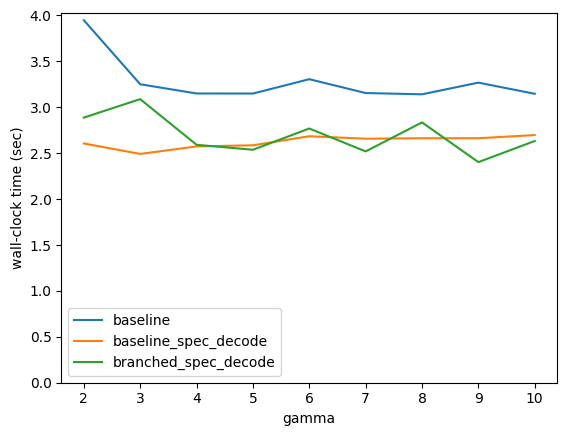

In [17]:
ax = df.groupby("gamma").mean().plot(ylabel="wall-clock time (sec)")
ylim_min, ylim_max = ax.get_ylim()
ax.set_ylim(0, ylim_max);

Mainly seems like there's more noise going from baseline speculative decoding to
branched speculative decoding. I'd need to run more and larger experiments to see what
effect it has. I didn't vary the number of branches or prompt sizes yet.